In [1]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing import timeseries_dataset_from_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

2024-12-09 02:17:02.818920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733728622.837827   39661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733728622.843149   39661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 02:17:02.861965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class DataPreprocess:
    def __init__(self):
        pass

    def load_data(self, path):
        df = pd.read_csv(path)
        df.drop("Unnamed: 0", inplace=True, axis = 1)
        return df

    def get_bid_levels(self, df, bid_levels):
        df_tmp = pd.DataFrame()
        df_tmp['time'] = pd.to_datetime(df['system_time'])
        df_tmp['midpoint'] = df['midpoint']
        
        # Filter ask and bid volume columns
        ask_cols = [f'asks_limit_notional_{i}' for i in range(bid_levels)]
        bid_cols = [f'bids_limit_notional_{i}' for i in range(bid_levels)]
        ask_cols = [col for col in ask_cols if col in df.columns]
        bid_cols = [col for col in bid_cols if col in df.columns]
        
        # Assign ask and bid volumes
        for lvls in range(len(ask_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_volume{lvls}'] = df[ask_cols[lvls]]
        for lvls in range(len(bid_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_volume{lvls}'] = df[bid_cols[lvls]]
        
        # Filter ask and bid distance columns
        ask_distance_cols = [f'asks_distance_{i}' for i in range(bid_levels)]
        bid_distance_cols = [f'bids_distance_{i}' for i in range(bid_levels)]
        ask_distance_cols = [col for col in ask_distance_cols if col in df.columns]
        bid_distance_cols = [col for col in bid_distance_cols if col in df.columns]
        
        # Assign ask and bid prices
        for lvls in range(len(ask_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[ask_distance_cols[lvls]])
        for lvls in range(len(bid_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[bid_distance_cols[lvls]])
        return df_tmp

    """
        For a actively traded stock,
        1. If there is an increase in the bid price in future compared to its current or previous value.
            We take the Bid volume.
        2. If the previous and current price is same we take the difference in the volume.
        3. If the current price is less than the current one then we take -ve of the current volume.

        Order Flow Imbalance is actually a factor that denotes the buying side or selling pressue for a particular stock at that level.
        When OFI > 0 it means that market is dominated by sellers. Lot more bids have happened.
        When OFI < 0 it means that market is dominated by buyers. Lot more asks have happened.
    """
    def get_bid_with_ofi_levels(self, df_tmp, bid_levels):
        for lvls in range(bid_levels):
            bid_price = df_tmp[f'bid_price{lvls}']
            ask_price = df_tmp[f'ask_price{lvls}']
            bid_volume = df_tmp[f'bid_volume{lvls}']
            ask_volume = df_tmp[f'ask_volume{lvls}']
            
            # Shift prices and volumes to compute differences
            bid_price_prev = bid_price.shift(1)
            ask_price_prev = ask_price.shift(1)
            bid_volume_prev = bid_volume.shift(1)
            ask_volume_prev = ask_volume.shift(1)
            
            # Calculate bid and ask order flows
            bid_of = np.where(
                bid_price > bid_price_prev, bid_volume,
                np.where(bid_price == bid_price_prev, bid_volume - bid_volume_prev, -bid_volume)
            )
            ask_of = np.where(
                ask_price > ask_price_prev, -ask_volume,
                np.where(ask_price == ask_price_prev, ask_volume - ask_volume_prev, ask_volume)
            )
            
            # Calculate OFI
            df_tmp[f'ofi_level{lvls}'] = bid_of - ask_of
        return df_tmp

    
    def make_window(self, window_size, dataframe, partition):
        normalized_df = df_new.to_numpy()
        dataframe.drop("time", inplace=True, axis = 1)
        train_length = int(len(normalized_df) * partition)
        data_length = len(normalized_df)
        
        midpoint_idx = df_new.columns.get_loc("midpoint")
        
        windows_train = timeseries_dataset_from_array(
            normalized_df[:train_length],  # Features for training
            normalized_df[window_size:train_length + window_size, midpoint_idx],  # Labels for training
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False,
            seed=None
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            normalized_df[train_length:data_length - window_size],  # Features for testing
            normalized_df[train_length + window_size:, midpoint_idx],  # Labels for testing
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False
        )
        return windows_train, windows_test

    """
        Returns x_train, y_train, x_test, y_test
    """
    def make_generic_window(self, window_size, df, partition, make_window=False):
        feature_columns = [col for col in df.columns if col != 'midpoint' and col != 'time']
        X, y = [], []

        if make_window:
            # Create sliding windows
            for i in range(len(df) - window_size):
                X.append(df.iloc[i:i + window_size][feature_columns].values)
                y.append(df.iloc[i + window_size]['midpoint'])
            
            X = np.array(X)
            y = np.array(y)
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            return X_train, X_test, y_train, y_test
        else:
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            
            return X_train, X_test, y_train, y_test

    def normalize_data(self, df, train_length):
        """
        Normalizes data based on the training dataset mean and std.
        """
        if "time" in df.columns:
            df = df.drop(columns=["time"])
        mean_df = df[:train_length].mean()
        std_df = df[:train_length].std()
        normalized_df = (df - mean_df) / std_df
        return normalized_df

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def r_get_window(self, df_tmp, train_length, window_size):
        # Drop time column (not needed for input features)
        df_tmp = df_tmp.drop(columns=["time"])
        
        # Split dataset into train and test sets
        data_length = df_tmp.shape[0]
        train_length = round(0.8 * data_length)  # 80% training data
        
        # normalized_df = dp.normalize_data(df_tmp, train_length)

        data_array = df_tmp.to_numpy()
        
        X = data_array[:, 1:]  # All columns except the first ('midpoint')
        #y = df_tmp["midpoint"]
        y = data_array[:, 0]   # The first column is 'midpoint'
        
        windows_train = timeseries_dataset_from_array(
            X[:train_length],                    # Features for training
            y[window_size:(train_length+window_size)],  # Target (midpoint) for training
            sequence_length=window_size,        # Length of each input sequence
            sequence_stride=1,                  # Step size for creating sequences
            sampling_rate=1,                    # Sample every time step
            batch_size=64,                      # Batch size
            shuffle=False                        # Shuffle training data
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            X[train_length:(data_length-window_size)],  # Features for testing
            y[train_length + window_size:],            # Target (midpoint) for testing
            sequence_length=window_size,               # Length of each input sequence
            sequence_stride=1,                         # Step size for creating sequences
            sampling_rate=1,                           # Sample every time step
            batch_size=64,                             # Batch size
            shuffle=False                              # Do not shuffle test data
        )
        
        return windows_train, windows_test

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def plot_graph(self, y_test, y_pred):
        # Plotting the graphs
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label="Actual", color="blue")
        plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
        plt.legend()
        plt.title("Actual vs Predicted Values")
        plt.xlabel("Sample Index")
        plt.ylabel("Target Value")
        plt.show()

    def get_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Mean Squared Error: {mse}")
        print(f"R² Score: {r2}")
        
        dp.plot_graph(y_test, y_pred)

In [3]:
dp = DataPreprocess()

df = dp.load_data('archive/ETH_1min.csv')

In [4]:
def train_model_and_get_result(lvls, window_size, is_ofi):
    df_one = dp.get_bid_levels(df, lvls)
    df_one.head()
    if is_ofi:
        df_one = dp.get_bid_with_ofi_levels(df_one, lvls)
        
    data_length = df_one.shape[0]
    train_length = round(0.8*data_length)
    
    windows_train, windows_test = dp.r_get_window(df_one, train_length, window_size)
    
    # Extract training data
    X_train, y_train = dp.extract_data_from_dataset(windows_train)
    
    # Extract testing data
    X_test, y_test = dp.extract_data_from_dataset(windows_test)
    
    print(X_train.shape)
    # Flatten training and testing data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each window
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    # Initialize scaler
    scaler = StandardScaler()
    # Fit and transform training data
    X_train_scaled = scaler.fit_transform(X_train_flat)
    # Transform testing data
    X_test_scaled = scaler.transform(X_test_flat)
    
    y_train_reshaped = y_train.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)
    y_train_scaled = scaler.fit_transform(y_train_reshaped)
    y_test_scaled = scaler.transform(y_test_reshaped)
    y_train_scaled = y_train_scaled.flatten()
    y_test_scaled = y_test_scaled.flatten()
    
    input_layer = Input(shape = (X_train_scaled.shape[1], 1))
    conv_layer = Conv1D(filters = 1, kernel_size = (((int (is_ofi)) * lvls) + (lvls * 4)), strides = (((int (is_ofi)) * lvls) + (lvls * 4)), activation = 'linear')(input_layer)
    flatten_layer = Flatten()(conv_layer)
    feature_extractor = Model(inputs = input_layer, outputs = flatten_layer)
    
    X_train_features = feature_extractor.predict(X_train_scaled)
    X_test_features = feature_extractor.predict(X_test_scaled)
    
    svr = SVR(kernel='linear', C = 10, epsilon=0.2)
    svr.fit(X_train_features, y_train_scaled)
    y_pred = svr.predict(X_test_features)

    # Calculate metrics
    mse = mean_squared_error(y_test , (y_pred * y_train.std() + y_train.mean()))
    r2 = r2_score(y_test, (y_pred * y_train.std() + y_train.mean()))
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")

    # Plot
    plt.plot((y_pred * y_train.std() + y_train.mean()), color="red", label="Prediction")
    plt.plot(y_test,color="blue", label="True Price")
    plt.legend(loc="upper right")
    plt.show()

metrics for  lvl -  5 window -  100 ofi -  True
(13589, 100, 25)
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 824.9003001275809
R² Score: 0.941573637637215


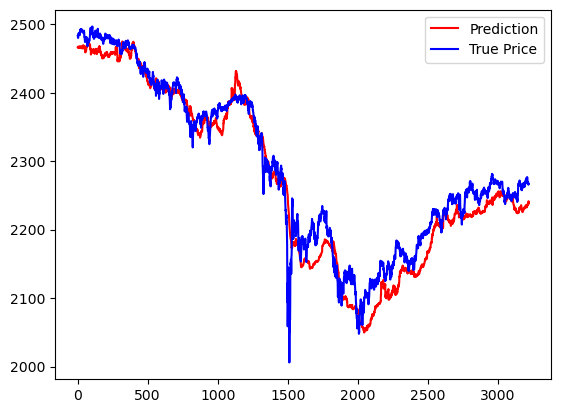

metrics for  lvl -  5 window -  100 ofi -  False
(13589, 100, 20)
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error: 3296.694923403467
R² Score: 0.7665003974849633


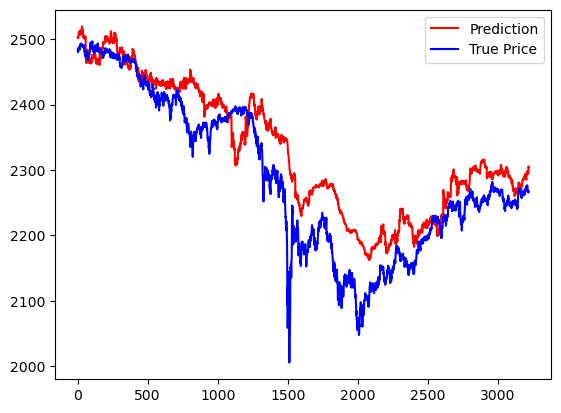

metrics for  lvl -  10 window -  100 ofi -  True
(13589, 100, 50)
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 1880.6113442364353
R² Score: 0.8667993212695786


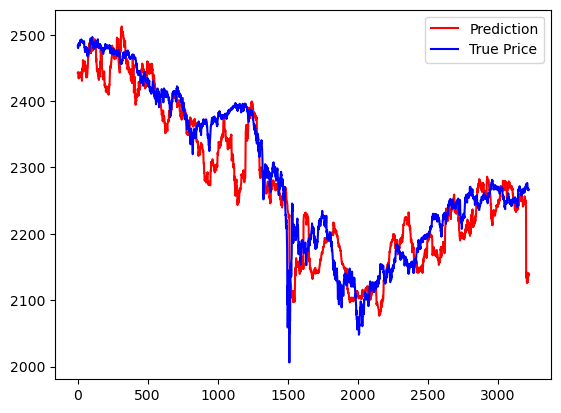

metrics for  lvl -  10 window -  100 ofi -  False


2024-12-09 02:55:57.851884: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(13589, 100, 40)
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error: 1041.2828541178053
R² Score: 0.9262476091384226


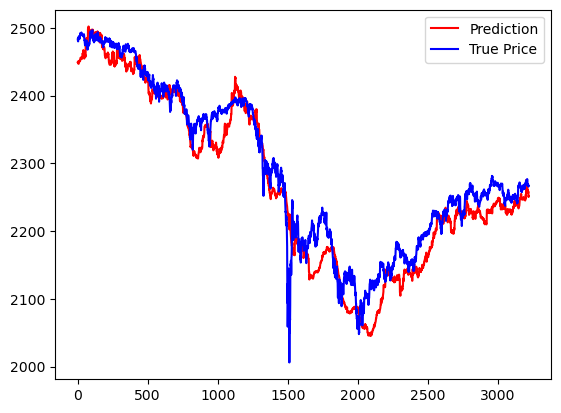

In [6]:
ofi_flag = [True, False]
window_size = [100]
lvls = [5, 10]

for wd in window_size:
    for lvl in lvls:
        for ofi in ofi_flag:
            print("metrics for ", "lvl - ", lvl, "window - ", wd, "ofi - " ,ofi)
            train_model_and_get_result(lvl, wd, ofi)